In [117]:
import os
import time
import numpy as np
import numpy.random as npr
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma

assert os.path.exists("/Users/daany/Downloads/HT/LDA/ap.txt") and os.path.exists("/Users/daany/Downloads/HT/LDA/vocab.txt")

with open("vocab.txt", "r") as f:
    vocab = set(f.read().splitlines())

with open("ap.txt", "r") as f:
    raw_text = f.read()

texts = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
stop_words = set(stopwords.words("english"))
documents = []

for text in texts:
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word in vocab]
    documents.append(tokens)

N = len(documents)
V = len(vocab)

doc_term_matrix = np.zeros((N, V))
vocab_to_index = {word: i for i, word in enumerate(vocab)}

for doc_idx, tokens in enumerate(documents):
    token_counts = Counter(tokens)
    for token, count in token_counts.items():
        if token in vocab_to_index:
            term_idx = vocab_to_index[token]
            doc_term_matrix[doc_idx, term_idx] = count

nonzero_idxs = []
for doc in doc_term_matrix:
    nonzero_idx = np.where(doc > 0)[0]
    nonzero_idxs.append(sorted(nonzero_idx))

ETA = 1 / V
ALPHA = 0.5
K = 30 

def init_variational_params(doc_term_matrix, K, rand_state=0):
    N, V = doc_term_matrix.shape # N is number of documents
    # rs = npr.RandomState(rand_state)
    # LAMBDA = rs.random(size=(K, V)) + 0.001
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in doc_term_matrix:
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_p_z_x += doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:, idx]) - digamma(np.sum(LAMBDA, axis=1))))
            corr_idx += 1
    ELBO += E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_z += -doc[idx] * np.sum(PHI[i][corr_idx] * np.log(PHI[i][corr_idx]))
            corr_idx += 1
    ELBO += E_q_log_z

    return ELBO

def log_sum_exp(vec):
    a = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - a))) + a

    return log_sum_exp

def update_variational_params(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape

    print("Updating PHI and GAMMA")
    for i in tqdm(range(N)):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((K, ))
            for k in range(K):
                exponent = digamma(GAMMA[i][k]) - digamma(np.sum(GAMMA[i])) \
                    + digamma(LAMBDA[k][idx]) - digamma(np.sum(LAMBDA[k]))
                log_PHI_ij[k] = exponent
            PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
            PHI[i][corr_idx] = PHI_ij
            corr_idx += 1

        GAMMA_i = np.zeros((K, )) + ALPHA
        for k in range(K):
            GAMMA_i[k] += np.sum(doc[nonzero_idx] * PHI[i][:, k])
        GAMMA[i] = GAMMA_i

    print("Updating LAMBDA")
    for k in tqdm(range(K)):
        LAMBDA_k = np.zeros((V, )) + ETA
        for i in range(N):
            doc = doc_term_matrix[i]
            nonzero_idx = nonzero_idxs[i]
            corr_idx = 0
            for idx in nonzero_idx:
                LAMBDA_k[idx] += PHI[i][corr_idx][k]
                corr_idx += 1
        LAMBDA[k] = LAMBDA_k

    return LAMBDA, GAMMA, PHI

In [134]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]

with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

stop_words = set(stopwords.words("english"))
corpus_matrix = []
for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_idxs = [vocab_to_idx[word] for word in filtered_tokens if word in vocab_to_idx]
    corpus_matrix.append(word_idxs)

In [230]:
def init_variational_params(corpus_matrix, K, V=len(vocab)):
    N = len(corpus_matrix)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in corpus_matrix:
        doc = np.asarray(doc)
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = 0
    for k in range(K):
        E_q_log_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_q_log_BETA

    E_q_log_THETA = 0
    for i in range(N):
        E_q_log_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j]))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    for i, doc in enumerate(tqdm(corpus_matrix, desc="Updating LAMBDA")):
        PHI_doc = PHI[i]
        for j, word in enumerate(doc):
            LAMBDA[:, word] += PHI_doc[j, :]

    ETA_matrix = np.full((K, V), ETA)
    LAMBDA = LAMBDA + ETA_matrix

    return LAMBDA, GAMMA, PHI

In [269]:
K = 30
V = len(vocab)
ETA = 1/V
ALPHA = 0.5

tol = 300
iteration = 1
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_matrix, K)
ELBOs.append(compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K))
print(f"Initial ELBO: {ELBOs[0]}\n")

while np.abs(curr_ELBO - prev_ELBO) > tol:
    print(f"Iteration: {iteration}")
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K)
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)
    iteration += 1
    print("\n")
stop = time.time()

Initial ELBO: -2628196.7827903796

Iteration: 1


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4912.15it/s]


Current ELBO: -1013162.1538323348


Iteration: 2


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4880.41it/s]


Current ELBO: -1033285.101265735


Iteration: 3


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4630.23it/s]


Current ELBO: -1051369.8711890283


Iteration: 4


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4563.20it/s]


Current ELBO: -1065126.9396461234


Iteration: 5


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4578.68it/s]


Current ELBO: -1074866.9858324004


Iteration: 6


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4634.87it/s]


Current ELBO: -1080723.437489162


Iteration: 7


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4118.54it/s]


Current ELBO: -1082506.8604513851


Iteration: 8


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4561.74it/s]


Current ELBO: -1079744.3020680079


Iteration: 9


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4187.93it/s]


Current ELBO: -1071749.7486725491


Iteration: 10


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4668.46it/s]


Current ELBO: -1057724.4603878655


Iteration: 11


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3756.87it/s]


Current ELBO: -1036921.6515241335


Iteration: 12


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4658.87it/s]


Current ELBO: -1008900.3199154482


Iteration: 13


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4382.65it/s]


Current ELBO: -973818.772673221


Iteration: 14


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4403.65it/s]


Current ELBO: -932623.7306768983


Iteration: 15


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4710.21it/s]


Current ELBO: -887015.8898576585


Iteration: 16


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4573.29it/s]


Current ELBO: -839186.8301187563


Iteration: 17


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4368.93it/s]


Current ELBO: -791393.7411957893


Iteration: 18


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4498.48it/s]


Current ELBO: -745519.3346417231


Iteration: 19


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4560.41it/s]


Current ELBO: -702813.4822563007


Iteration: 20


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4716.35it/s]


Current ELBO: -663899.5473850367


Iteration: 21


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4550.40it/s]


Current ELBO: -628864.8811341927


Iteration: 22


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4490.80it/s]


Current ELBO: -597469.8663948965


Iteration: 23


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4158.31it/s]


Current ELBO: -569331.3865567206


Iteration: 24


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4457.81it/s]


Current ELBO: -543994.800637609


Iteration: 25


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4092.71it/s]


Current ELBO: -521000.2297152247


Iteration: 26


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4488.00it/s]


Current ELBO: -500010.4149012687


Iteration: 27


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4501.04it/s]


Current ELBO: -480820.55881576193


Iteration: 28


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4596.38it/s]


Current ELBO: -463245.49881543004


Iteration: 29


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4451.54it/s]


Current ELBO: -447100.6800100783


Iteration: 30


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4391.73it/s]


Current ELBO: -432193.3065611248


Iteration: 31


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4372.46it/s]


Current ELBO: -418367.0728961271


Iteration: 32


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4545.80it/s]


Current ELBO: -405468.5971110873


Iteration: 33


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4601.63it/s]


Current ELBO: -393387.087503217


Iteration: 34


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4459.27it/s]


Current ELBO: -382086.43854411365


Iteration: 35


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4390.16it/s]


Current ELBO: -371517.1879424332


Iteration: 36


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4573.15it/s]


Current ELBO: -361598.9191776129


Iteration: 37


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4552.77it/s]


Current ELBO: -352257.8722303994


Iteration: 38


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4579.80it/s]


Current ELBO: -343436.4945562179


Iteration: 39


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4532.41it/s]


Current ELBO: -335089.12702123984


Iteration: 40


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4436.65it/s]


Current ELBO: -327182.90717502765


Iteration: 41


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4284.42it/s]


Current ELBO: -319689.3414681407


Iteration: 42


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4600.31it/s]


Current ELBO: -312577.4461202862


Iteration: 43


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4354.82it/s]


Current ELBO: -305814.93339872285


Iteration: 44


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4569.66it/s]


Current ELBO: -299370.6467405346


Iteration: 45


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4544.21it/s]


Current ELBO: -293213.55810720404


Iteration: 46


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4092.00it/s]


Current ELBO: -287338.8759350719


Iteration: 47


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4119.83it/s]


Current ELBO: -281739.8689232484


Iteration: 48


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4131.23it/s]


Current ELBO: -276393.37597215525


Iteration: 49


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4452.79it/s]


Current ELBO: -271278.20849373745


Iteration: 50


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4460.50it/s]


Current ELBO: -266377.3962050835


Iteration: 51


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4330.26it/s]


Current ELBO: -261676.66777800338


Iteration: 52


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4392.72it/s]


Current ELBO: -257163.23130806198


Iteration: 53


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4522.26it/s]


Current ELBO: -252826.2166694721


Iteration: 54


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4088.16it/s]


Current ELBO: -248657.03437635297


Iteration: 55


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4434.76it/s]


Current ELBO: -244647.59168368258


Iteration: 56


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4318.00it/s]


Current ELBO: -240788.46462882299


Iteration: 57


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4590.72it/s]


Current ELBO: -237065.54886160564


Iteration: 58


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4548.23it/s]


Current ELBO: -233462.13569922


Iteration: 59


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4361.46it/s]


Current ELBO: -229982.79697643657


Iteration: 60


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4486.44it/s]


Current ELBO: -226634.64619809983


Iteration: 61


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4519.03it/s]


Current ELBO: -223408.82232837006


Iteration: 62


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4450.16it/s]


Current ELBO: -220294.82493188928


Iteration: 63


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4473.82it/s]


Current ELBO: -217284.98602616534


Iteration: 64


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4535.78it/s]


Current ELBO: -214373.43767849432


Iteration: 65


Updating LAMBDA: 100%|██████████| 2246/2246 [00:01<00:00, 1663.29it/s]


Current ELBO: -211555.28627857784


Iteration: 66


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4641.77it/s]


Current ELBO: -208826.27156515574


Iteration: 67


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4623.38it/s]


Current ELBO: -206182.55058369186


Iteration: 68


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 5131.55it/s]


Current ELBO: -203620.58844878874


Iteration: 69


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 5069.64it/s]


Current ELBO: -201137.09372919894


Iteration: 70


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 5137.52it/s]


Current ELBO: -198728.91079971456


Iteration: 71


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3696.20it/s]


Current ELBO: -196392.92300588285


Iteration: 72


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3982.13it/s]


Current ELBO: -194126.03357339805


Iteration: 73


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 2527.83it/s]


Current ELBO: -191925.23024950598


Iteration: 74


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 2682.81it/s]


Current ELBO: -189787.67473804465


Iteration: 75


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4685.42it/s]


Current ELBO: -187710.73508062703


Iteration: 76


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4115.35it/s]


Current ELBO: -185691.96846043583


Iteration: 77


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3381.08it/s]


Current ELBO: -183729.09445024445


Iteration: 78


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3382.78it/s]


Current ELBO: -181819.97286020516


Iteration: 79


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4085.06it/s]


Current ELBO: -179962.58268494427


Iteration: 80


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4242.04it/s]


Current ELBO: -178154.997919547


Iteration: 81


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3894.96it/s]


Current ELBO: -176395.37003212632


Iteration: 82


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3511.22it/s]


Current ELBO: -174681.92313812333


Iteration: 83


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3814.61it/s]


Current ELBO: -173012.95365735382


Iteration: 84


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3302.91it/s]


Current ELBO: -171386.83167518262


Iteration: 85


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4030.52it/s]


Current ELBO: -169801.998284545


Iteration: 86


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3939.99it/s]


Current ELBO: -168256.95378634427


Iteration: 87


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3744.47it/s]


Current ELBO: -166750.24944477103


Iteration: 88


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4157.11it/s]


Current ELBO: -165280.49427547245


Iteration: 89


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3961.02it/s]


Current ELBO: -163846.36474942742


Iteration: 90


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4160.47it/s]


Current ELBO: -162446.6063211817


Iteration: 91


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4284.28it/s]


Current ELBO: -161080.03244813887


Iteration: 92


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4815.47it/s]


Current ELBO: -159745.52437495475


Iteration: 93


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4018.57it/s]


Current ELBO: -158442.0289677646


Iteration: 94


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4055.90it/s]


Current ELBO: -157168.55280368403


Iteration: 95


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3288.20it/s]


Current ELBO: -155924.1539950945


Iteration: 96


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4108.66it/s]


Current ELBO: -154707.93486749975


Iteration: 97


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3132.97it/s]


Current ELBO: -153519.03693793432


Iteration: 98


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3467.75it/s]


Current ELBO: -152356.63559409574


Iteration: 99


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3992.81it/s]


Current ELBO: -151219.92875757487


Iteration: 100


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 2843.55it/s]


Current ELBO: -150108.1158533709


Iteration: 101


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 2398.19it/s]


Current ELBO: -149020.3728163273


Iteration: 102


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3249.24it/s]


Current ELBO: -147955.83990592635


Iteration: 103


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3733.58it/s]


Current ELBO: -146913.63309704405


Iteration: 104


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4167.11it/s]


Current ELBO: -145892.88337031723


Iteration: 105


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3070.20it/s]


Current ELBO: -144892.8294511058


Iteration: 106


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3839.62it/s]


Current ELBO: -143912.94844102245


Iteration: 107


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3359.85it/s]


Current ELBO: -142952.9659919804


Iteration: 108


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3486.73it/s]


Current ELBO: -142012.62930932015


Iteration: 109


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3937.05it/s]


Current ELBO: -141091.47988867934


Iteration: 110


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3853.35it/s]


Current ELBO: -140188.87500831633


Iteration: 111


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3481.43it/s]


Current ELBO: -139304.13520819283


Iteration: 112


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3796.73it/s]


Current ELBO: -138436.65828363426


Iteration: 113


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3948.83it/s]


Current ELBO: -137585.9185828041


Iteration: 114


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4041.63it/s]


Current ELBO: -136751.43034169025


Iteration: 115


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4038.89it/s]


Current ELBO: -135932.72915731336


Iteration: 116


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3480.42it/s]


Current ELBO: -135129.36475855982


Iteration: 117


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4140.59it/s]


Current ELBO: -134340.89916532632


Iteration: 118


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3778.36it/s]


Current ELBO: -133566.9077688795


Iteration: 119


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3679.91it/s]


Current ELBO: -132806.98101894037


Iteration: 120


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3816.56it/s]


Current ELBO: -132060.72520465156


Iteration: 121


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4542.82it/s]


Current ELBO: -131327.76238747395


Iteration: 122


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4751.51it/s]


Current ELBO: -130607.73009368574


Iteration: 123


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4384.45it/s]


Current ELBO: -129900.28104400175


Iteration: 124


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4291.09it/s]


Current ELBO: -129205.08291290762


Iteration: 125


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4317.25it/s]


Current ELBO: -128521.81804666632


Iteration: 126


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4019.82it/s]


Current ELBO: -127850.18301514004


Iteration: 127


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4402.33it/s]


Current ELBO: -127189.88784595297


Iteration: 128


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4442.90it/s]


Current ELBO: -126540.65477238211


Iteration: 129


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4501.52it/s]


Current ELBO: -125902.21641898327


Iteration: 130


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4036.19it/s]


Current ELBO: -125274.3135629243


Iteration: 131


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4507.27it/s]


Current ELBO: -124656.69301484106


Iteration: 132


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4389.64it/s]


Current ELBO: -124049.10649387357


Iteration: 133


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4430.30it/s]


Current ELBO: -123451.31107219262


Iteration: 134


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4422.44it/s]


Current ELBO: -122863.0706919853


Iteration: 135


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4436.26it/s]


Current ELBO: -122284.15762340307


Iteration: 136


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4497.77it/s]


Current ELBO: -121714.35327382418


Iteration: 137


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3923.80it/s]


Current ELBO: -121153.44849953073


Iteration: 138


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4476.93it/s]


Current ELBO: -120601.24361258202


Iteration: 139


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4232.35it/s]


Current ELBO: -120057.5480671126


Iteration: 140


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4391.39it/s]


Current ELBO: -119522.17977630836


Iteration: 141


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4341.43it/s]


Current ELBO: -118994.96422021525


Iteration: 142


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4028.18it/s]


Current ELBO: -118475.73365836448


Iteration: 143


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4451.33it/s]


Current ELBO: -117964.32657986101


Iteration: 144


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4421.52it/s]


Current ELBO: -117460.58721204234


Iteration: 145


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4516.52it/s]


Current ELBO: -116964.36489037701


Iteration: 146


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4589.14it/s]


Current ELBO: -116475.51332597138


Iteration: 147


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4475.37it/s]


Current ELBO: -115993.88992520346


Iteration: 148


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4456.09it/s]


Current ELBO: -115519.35521376514


Iteration: 149


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4483.38it/s]


Current ELBO: -115051.77235839199


Iteration: 150


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4374.79it/s]


Current ELBO: -114591.00673940722


Iteration: 151


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4522.98it/s]


Current ELBO: -114136.92562287269


Iteration: 152


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4365.61it/s]


Current ELBO: -113689.39796270308


Iteration: 153


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4291.14it/s]


Current ELBO: -113248.29436989913


Iteration: 154


Updating LAMBDA: 100%|██████████| 2246/2246 [00:01<00:00, 1169.58it/s]


Current ELBO: -112813.48720674923


Iteration: 155


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3649.15it/s]


Current ELBO: -112384.85075075326


Iteration: 156


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3080.77it/s]


Current ELBO: -111962.26135412478


Iteration: 157


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3355.36it/s]


Current ELBO: -111545.5975688344


Iteration: 158


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3843.42it/s]


Current ELBO: -111134.74023151555


Iteration: 159


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3033.87it/s]


Current ELBO: -110729.57252256607


Iteration: 160


Updating LAMBDA: 100%|██████████| 2246/2246 [00:01<00:00, 2211.96it/s]


Current ELBO: -110329.98000827072


Iteration: 161


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3785.82it/s]


Current ELBO: -109935.85067532881


Iteration: 162


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3900.26it/s]


Current ELBO: -109547.07495173902


Iteration: 163


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3837.28it/s]


Current ELBO: -109163.5457180854


Iteration: 164


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3762.65it/s]


Current ELBO: -108785.15830448015


Iteration: 165


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3609.99it/s]


Current ELBO: -108411.81047329213


Iteration: 166


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3519.11it/s]


Current ELBO: -108043.40239649315


Iteration: 167


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3808.93it/s]


Current ELBO: -107679.83661430178


Iteration: 168


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3776.19it/s]


Current ELBO: -107321.01798752097


Iteration: 169


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3564.04it/s]


Current ELBO: -106966.85363069474


Iteration: 170


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3788.77it/s]


Current ELBO: -106617.25283329072


Iteration: 171


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3778.58it/s]


Current ELBO: -106272.12697065575


Iteration: 172


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3239.71it/s]


Current ELBO: -105931.38940186665


Iteration: 173


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3975.23it/s]


Current ELBO: -105594.95537166845


Iteration: 174


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3858.30it/s]


Current ELBO: -105262.74192228852


Iteration: 175


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3982.98it/s]


Current ELBO: -104934.66781648845


Iteration: 176


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3980.52it/s]


Current ELBO: -104610.65348254418


Iteration: 177


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3965.39it/s]


Current ELBO: -104290.62096197289


Iteration: 178


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3866.11it/s]


Current ELBO: -103974.49385483781


Iteration: 179


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3382.67it/s]


Current ELBO: -103662.19725075187


Iteration: 180


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3752.17it/s]


Current ELBO: -103353.65763083343


Iteration: 181


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3593.65it/s]


Current ELBO: -103048.80276363065


Iteration: 182


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3813.20it/s]


Current ELBO: -102747.56158749168


Iteration: 183


Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3370.79it/s]


Current ELBO: -102449.8641146626




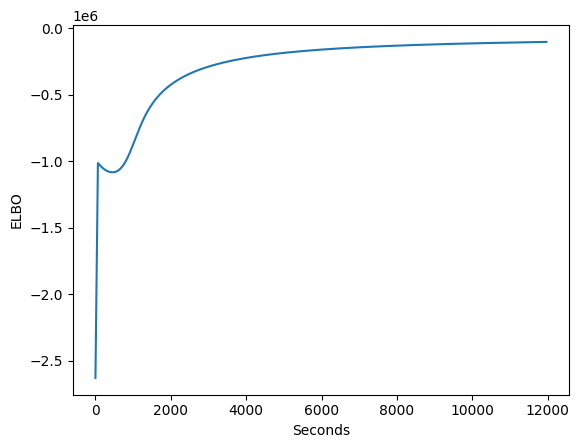

In [270]:
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)

In [272]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-7:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

top_words

{0: ['party', 'court', 'percent', 'police', 'gorbachev', 'states', 'two'],
 1: ['percent', 'new', 'two', 'company', 'president', 'york', 'time'],
 2: ['soviet', 'state', 'million', 'first', 'new', 'department', 'government'],
 3: ['year', 'today', 'york', 'says', 'spokesman', 'monday', 'market'],
 4: ['new', 'time', 'united', 'million', 'soviet', 'world', 'told'],
 5: ['year', 'million', 'years', 'today', 'two', 'dukakis', 'house'],
 6: ['united', 'bush', 'president', 'states', 'soviet', 'reagan', 'national'],
 7: ['percent', 'new', 'people', 'million', 'year', 'two', 'government'],
 8: ['last', 'state', 'two', 'year', 'officials', 'government', 'first'],
 9: ['party', 'united', 'defense', 'case', 'expected', 'day', 'money'],
 10: ['cdy', 'clr', 'rn', 'company', 'million', 'first', 'two'],
 11: ['percent', 'time', 'bush', 'billion', 'friday', 'police', 'million'],
 12: ['people', 'officials', 'percent', 'years', 'today', 'back', 'american'],
 13: ['new', 'year', 'national', 'friday', '

In [ ]:
word_topics = []
for i, doc in enumerate(corpus_matrix):
    PHI_doc = PHI[i]
    topics = np.argmax(PHI_doc, axis=1)
    word_topics.append([(vocab[word], topics[j]) for j, word in enumerate(doc)])

for i, doc_topics in enumerate(word_topics[1:2]):
    print(f"Document {i+1}:")
    for word, topic in doc_topics:
        print(f"    {word}: Topic {topic}")